In [243]:
import cv2
import tensorflow as tf
try:
    import matlab.engine
    MATLAB_ENGINE = matlab.engine.start_matlab("-nojvm")
except ImportError as err:
    print(err)
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imsave, imread
from skimage import img_as_float
from matlab_imresize import imresize
import PIL.Image as Image

In [252]:
def rgb2luma(rgb):
    # ycbcr = origT * rgb + origOffset;
    rgb = rgb / 255.0
    coef = [65.481, 128.553, 24.966]
    offset = 16
    r, g, b = rgb[:, :, 0], rgb[:, :, 1], rgb[:, :, 2]
    return r * coef[0] + g * coef[1] + b * coef[2] + offset

def rgb2ycbcr(rgb):
    # ycbcr = origT * rgb + origOffset;
    rgb = rgb / 255.0
    T = np.asarray([[65.4810, 128.5530, 24.9660],
                        [-37.7970, -74.2030, 112.0000],
                        [112.0000, -93.7860, -18.2140]])
    offset = np.asarray([16, 128, 128])
    ycbcr = np.dot(rgb, T.T)
    ycbcr[:,:,0] += offset[0]
    ycbcr[:,:,1] += offset[1]
    ycbcr[:,:,2] += offset[2]
    return ycbcr

def ycbcr2rgb(ycbcr):
    ycbcr = ycbcr.copy()
    Tinv = np.asarray([[0.00456621, 0., 0.00625893],
                           [0.00456621, -0.00153632, -0.00318811],
                           [0.00456621, 0.00791071, 0.]])
    offset = np.asarray([16, 128, 128])
    ycbcr[:,:,0] -= offset[0]
    ycbcr[:,:,1] -= offset[1]
    ycbcr[:,:,2] -= offset[2]
    rgb = (np.dot(ycbcr, Tinv.T) * 255.0)
    return rgb

In [ ]:
im = imread('pic/jordan.jpeg')
im_luma = rgb2luma(im)
im_ycbcr = rgb2ycbcr(im)
im_rgb = ycbcr2rgb(im_ycbcr)

In [254]:
print(np.mean(im_luma - im_ycbcr[:,:,0]))
print(np.mean(np.sqrt(np.square(im - im_rgb))))
diff = im/255.0 - im_rgb/255.0
print(np.mean(np.sqrt(np.square(diff))))

0.0
1.45512216533e-05
5.70636143262e-08


In [258]:
im_mat = MATLAB_ENGINE.imread('pic/jordan.jpeg')
im_mat = MATLAB_ENGINE.rgb2ycbcr(im_mat)
im_mat = np.asarray(im_mat, dtype=np.float32)

In [259]:
print(np.mean(np.sqrt(np.square(im_mat-im_ycbcr))))

0.350315641476


(128, 171, 3)
(171, 128, 3)


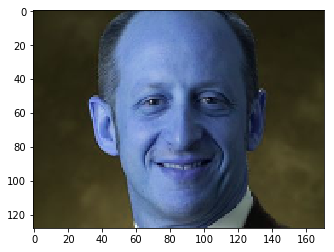

In [21]:
im = cv2.resize(im, (171, 128), interpolation=cv2.INTER_CUBIC)
print(im.shape)
plt.imshow(im)
#plt.show()
im = cv2.resize(im, (128, 171), interpolation=cv2.INTER_CUBIC)
#plt.imshow(im2)
print(im.shape)

In [8]:
def compute_psnr(diff):
    #print(im_mat)
    #print('********************************************************************')
    #print(im_cv2)
    #print(tf.square(diff).eval())
    MSE = tf.reduce_mean(tf.square(diff))
    print(MSE.eval())
    psnr = tf.multiply(tf.constant(20, dtype=tf.float32), tf.log(255/tf.sqrt(MSE))/tf.log(tf.constant(10, dtype=tf.float32)), name='psnr')
    return psnr

def imresize_bicubic_cv2(path, scale):
    im=cv2.imread(path)
    im=cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    im = im / 255.
    #print(im.shape)
    im_cv2=cv2.resize(im, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
    #print(im_cv2.shape)
    return im_cv2
    #plt.imshow(im_cv2)
    #plt.show()
    #cv2.imwrite('jordan_cv2.jpeg', im_cv2)

def imresize_bicubic_py(path, scale):
    im = imread(path)
    #im = cv2.imread(path).astype(np.uint8)[...,::-1]
    #import time
    #start_time = time.time()
    #for i in range(100):
    im = im / 255.
    im_py = imresize.imresize(im, scalar_scale=scale)
    #elapsed = time.time() - start_time
    #print('%.3f sec' % elapsed)
    #plt.imshow(im_py)
    #plt.show()
    #cv2.imwrite('jordan_py.jpeg', im_py)
    return im_py

def imresize_bicubic_mat(path, scale):
    im = MATLAB_ENGINE.imread(path)
    im = np.asarray(im) / 255.
    im = matlab.single(im.tolist())
    im_mat = MATLAB_ENGINE.imresize(im, scale, 'Antialiasing', True, 'Method', 'bicubic')
    im_mat = np.asarray(im_mat, dtype=np.float32)
    #im_mat = np.array(im_mat, dtype=np.uint8)
    #plt.imshow(im_mat)
    #plt.show()
    #cv2.imwrite('jordan_mat.jpeg', im_mat)
    return im_mat

def imresize_bicubic_pil(path, scale):
    im = Image.open(path)
    im_pil = im.resize((32,24),Image.BICUBIC)
    return im_pil

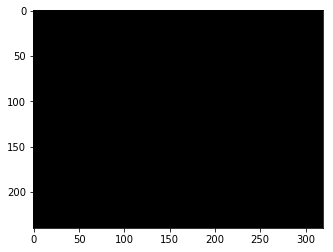

In [45]:
im1 = cv2.imread('pic/jordan.jpeg').astype(np.uint8)
im2 = np.asarray(MATLAB_ENGINE.imread('pic/jordan.jpeg'), dtype=np.uint8)[...,::-1]
#print(im1-im2)
plt.imshow(im1-im2)
plt.show()

In [4]:
import random
from os.path import join, isfile
from os import listdir
with tf.Session() as sess:
    path = '/home/wuzhenyu_sjtu/Desktop/SRCNN/Train'
    #path = '/home/wuzhenyu_sjtu/Desktop/C3D/pic'
    files = [join(path, f) for f in listdir(path) if isfile(join(path, f))]
    for file in files:
        scale = random.random()
        im_mat = imresize_bicubic_mat(file, scale)
        im_mat = matlab.single(im_mat.tolist())
        im_mat = MATLAB_ENGINE.imresize(im_mat, 1./scale, 'Antialiasing', True, 'Method', 'bicubic')
        im_mat = np.asarray(im_mat, dtype=np.float32)
        im_py = imresize_bicubic_py(file, scale)
        im_py = imresize.imresize(im_py, scalar_scale=1./scale)
        #print(im_mat)
        #print(im_py)
        diff = im_mat.astype(np.float32)-im_py.astype(np.float32)
        print(file)
        print(scale)
        print(np.max(diff))
        print(np.min(diff))
        print(compute_psnr(diff).eval())
        print('###############################################################')
    #print(compute_psnr(im_cv2.astype(np.float32), np.array(im_pil, dtype=np.float32)).eval())
    #print(compute_psnr(cv2.imread('jordan.jpeg').astype(np.float32)[...,::-1], np.array(MATLAB_ENGINE.imread('jordan.jpeg'), dtype=np.float32)).eval())

/home/wuzhenyu_sjtu/Desktop/SRCNN/Train/t64.bmp
0.905684645662592
1.19209e-07
-1.19209e-07
7.33822e-16
199.475
###############################################################
/home/wuzhenyu_sjtu/Desktop/SRCNN/Train/tt26.bmp
0.28777469346723306
1.19209e-07
-1.78814e-07
7.35659e-16
199.464
###############################################################
/home/wuzhenyu_sjtu/Desktop/SRCNN/Train/tt6.bmp
0.7904623864317549
1.19209e-07
-1.19209e-07
5.47084e-16
200.75
###############################################################
/home/wuzhenyu_sjtu/Desktop/SRCNN/Train/t20.bmp
0.6152757289783364
1.19209e-07
-5.96046e-08
1.01187e-15
198.08
###############################################################
/home/wuzhenyu_sjtu/Desktop/SRCNN/Train/t39.bmp
0.35021607430187784
1.19209e-07
-5.96046e-08
1.25621e-15
197.14
###############################################################
/home/wuzhenyu_sjtu/Desktop/SRCNN/Train/t61.bmp
0.6419299513743796
1.19209e-07
-1.19209e-07
7.76497e-16
199.229
#########

/home/wuzhenyu_sjtu/Desktop/SRCNN/Train/t17.bmp
0.3244402087779097
1.19209e-07
-1.19209e-07
6.10159e-16
200.276
###############################################################
/home/wuzhenyu_sjtu/Desktop/SRCNN/Train/tt4.bmp
0.4314104622155789
1.19209e-07
-1.19209e-07
5.5046e-16
200.724
###############################################################
/home/wuzhenyu_sjtu/Desktop/SRCNN/Train/t13.bmp
0.6431891535710862
1.19209e-07
-1.19209e-07
5.30997e-16
200.88
###############################################################
/home/wuzhenyu_sjtu/Desktop/SRCNN/Train/tt15.bmp
0.7712320021826288
1.19209e-07
-1.19209e-07
6.03674e-16
200.323
###############################################################
/home/wuzhenyu_sjtu/Desktop/SRCNN/Train/t66.bmp
0.9026493546695644
1.19209e-07
-1.19209e-07
1.17921e-15
197.415
###############################################################
/home/wuzhenyu_sjtu/Desktop/SRCNN/Train/tt17.bmp
0.661902969956741
1.19209e-07
-2.38419e-07
8.56236e-16
198.805
#########